In [1]:
# imports
from tueplots import bundles
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tueplots  import figsizes

import sys
%load_ext autoreload
%autoreload 2

sys.path.insert(0, '.')

In [49]:
from analysis import sweep2df, format_violin, BLUE, RED

In [3]:
plt.rcParams.update(bundles.neurips2022(usetex=True))
plt.rcParams.update({
    'text.latex.preamble': [r'\usepackage{amsfonts}', # mathbb
                            r'\usepackage{amsmath}'] # boldsymbol
})

# Data loading

In [16]:
# Constants
ENTITY = "ima-vae"
PROJECT = "dsprites"
SWEEP_ID = "7qg2q0aw"

# W&B API
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"dsprites_sweep_{SWEEP_ID}.csv"


runs_df = sweep2df(sweep.runs, filename, save=True, load=True)

# runs_df = runs_df[runs_df.gamma_square == 1.]

Encountered a faulty run with ID dark-sweep-50
Encountered a faulty run with ID ethereal-sweep-49
Encountered a faulty run with ID wise-sweep-48
Encountered a faulty run with ID ethereal-sweep-47
Encountered a faulty run with ID easy-sweep-46
Encountered a faulty run with ID soft-sweep-45
Encountered a faulty run with ID dandy-sweep-44
Encountered a faulty run with ID serene-sweep-41
Encountered a faulty run with ID firm-sweep-42
Encountered a faulty run with ID laced-sweep-40
Encountered a faulty run with ID floral-sweep-36
Encountered a faulty run with ID swept-sweep-8
Encountered a faulty run with ID stellar-sweep-4
Encountered a faulty run with ID sleek-sweep-3
Encountered a faulty run with ID whole-sweep-2


# Data pre-processing

In [33]:

mcc_history, cima_history = [], []
for run in sweep.runs:
    if run.name in runs_df[runs_df.gamma_square == 1.].name.tolist():
        mcc_history.append(run.history(keys=[f"Metrics/val/mcc"])[f"Metrics/val/mcc"].tolist())
        cima_history.append(run.history(keys=[f"Metrics/val/cima"])[f"Metrics/val/cima"].tolist())

In [36]:
min_len = np.array([len(m) for m in mcc_history]).min()

In [44]:
mcc = np.array([m[:min_len] for m in mcc_history])
cima = np.array([m[:min_len] for m in cima_history])

# Plot

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_75393/3850312672.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(0, min_len * val_epoch_factor, val_epoch_factor))


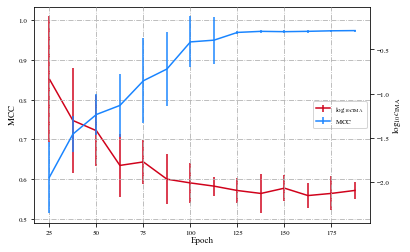

In [78]:
LABELPAD = 1
TICK_PADDING = 2

fig = plt.figure(figsize=figsizes.neurips2022(nrows=1, ncols=1)['figure.figsize'])

"""MCC vs CIMA over different gamma"""
ax = fig.add_subplot(111)

# create double y-axis
ax2 = ax.twinx()

# MCC
ax.errorbar(range(min_len), mcc.mean(0), yerr=mcc.std(0), label='mcc', c=BLUE)

# CIMA
ax2.errorbar(range(min_len), np.log10(cima).mean(0), yerr=np.log10(cima).std(0), label='cima', c=RED)


# set z-order to make CIMA the top plot
# https://stackoverflow.com/a/30506077/16912032
ax.set_zorder(ax.get_zorder()+1)
ax.set_frame_on(False)

ax2.set_ylabel("$\log_{10} c_{\mathrm{IMA}}$", labelpad=LABELPAD)
ax.set_ylabel("$\mathrm{MCC}$", labelpad=LABELPAD)

ax.set_xlabel("Epoch", labelpad=LABELPAD)
val_epoch_factor = 25
ax.set_xticklabels(range(0, min_len * val_epoch_factor, val_epoch_factor))
ax.grid(True, which="both", ls="-.")

handle1, label1 = ax.get_legend_handles_labels()
handle2, label2 = ax2.get_legend_handles_labels()

plt.legend([handle2[0], handle1[0]],["$\log_{10} c_{\mathrm{IMA}}$", "$\mathrm{MCC}$"], loc='center right')

plt.savefig("dsprites_mcc_cima.svg")

In [85]:
log_gamma_sq = np.log10(elbo_gap_data[:,0])
elbo = elbo_gap_data[:,1]
log_likelihood = elbo_gap_data[:,2]
ima = elbo_gap_data[:,3]



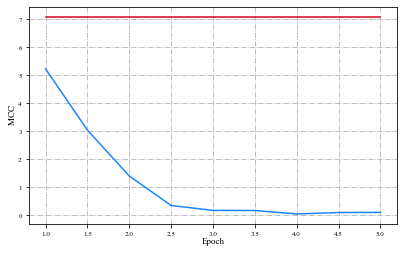